## Przewidywanie wypłacalności kredytobiorców

Ten projekt ma na celu nauczyć model przewidywać czy kredytobiorca spłaci kredyt. Będę korzystać z bibliotek do przetwarzania, analizy i wizualizacji danych tj. Pandas, NumPy, Matplotlib, oraz z biblioteki Scikitlearn. Jest to mój pierwszy większy projekt, więc ma on charakter głównie treningowy. Projekt jest w fazie rozwoju, cały czas nad nim pracuję i staram się co kilka dni wrzucać na Github poprawioną i rozbudowaną wersję

##### Projekt jest tworzony na podstawie tego zbioru danych
https://www.kaggle.com/gauravduttakiit/loan-defaulter

In [28]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

## Wstępna analiza danych

In [29]:
#wczytuję dane
data = pd.read_csv('application_data.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
#usuwam kolumnę 'SK_ID_CURR' i mieszam dane
data = data.drop(['SK_ID_CURR'], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,Cash loans,F,N,Y,0,202500.0,225000.0,12915.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
1,0,Cash loans,M,Y,Y,0,180000.0,595903.5,28795.5,481500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
2,0,Cash loans,F,Y,N,1,67500.0,225000.0,9909.0,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Cash loans,F,N,N,1,112500.0,343800.0,10791.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,Cash loans,M,Y,Y,1,112500.0,297130.5,21748.5,256500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


Class 0: 282686
Class 1: 24825
Proportion: 11.39 : 1


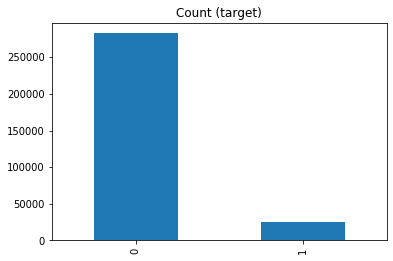

In [31]:
target_count = data['TARGET'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

klasa target jest niezbalansowana, skorzystam z metody losowego niepełnego próbkowania, żeby pozbyć się tego problemu

In [32]:
count_class_0, count_class_1 = data['TARGET'].value_counts()

class_0 = data[data['TARGET'] == 0]
class_1 = data[data['TARGET'] == 1]

Random under-sampling:
1    24825
0    24825
Name: TARGET, dtype: int64


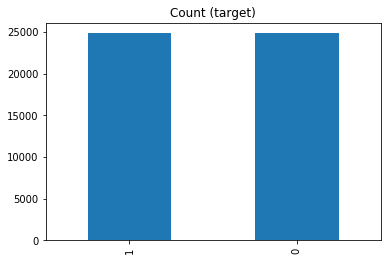

In [33]:
class_0_under = class_0.sample(count_class_1)
data_under = pd.concat([class_0_under, class_1], axis=0)

print('Random under-sampling:')
print(data_under['TARGET'].value_counts())

data_under['TARGET'].value_counts().plot(kind='bar', title='Count (target)');

In [34]:
data_under.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49650 entries, 116064 to 307510
Data columns (total 121 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   TARGET                        49650 non-null  int64  
 1   NAME_CONTRACT_TYPE            49650 non-null  object 
 2   CODE_GENDER                   49650 non-null  object 
 3   FLAG_OWN_CAR                  49650 non-null  object 
 4   FLAG_OWN_REALTY               49650 non-null  object 
 5   CNT_CHILDREN                  49650 non-null  int64  
 6   AMT_INCOME_TOTAL              49650 non-null  float64
 7   AMT_CREDIT                    49650 non-null  float64
 8   AMT_ANNUITY                   49650 non-null  float64
 9   AMT_GOODS_PRICE               49610 non-null  float64
 10  NAME_TYPE_SUITE               49473 non-null  object 
 11  NAME_INCOME_TYPE              49650 non-null  object 
 12  NAME_EDUCATION_TYPE           49650 non-null  object 

In [35]:
a = data_under.isna().mean()*100
a[a>0]

AMT_GOODS_PRICE                0.080564
NAME_TYPE_SUITE                0.356495
OWN_CAR_AGE                   67.599194
OCCUPATION_TYPE               28.624371
EXT_SOURCE_1                  57.850957
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     15.218530
AMT_REQ_CREDIT_BUREAU_WEEK    15.218530
AMT_REQ_CREDIT_BUREAU_MON     15.218530
AMT_REQ_CREDIT_BUREAU_QRT     15.218530
AMT_REQ_CREDIT_BUREAU_YEAR    15.218530
Length: 64, dtype: float64

In [36]:
a = data_under.isna().mean()*100
print(len(a[a>30]))
a[a>30]

49


OWN_CAR_AGE                     67.599194
EXT_SOURCE_1                    57.850957
APARTMENTS_AVG                  54.066465
BASEMENTAREA_AVG                61.399799
YEARS_BEGINEXPLUATATION_AVG     52.106747
YEARS_BUILD_AVG                 68.922457
COMMONAREA_AVG                  72.010070
ELEVATORS_AVG                   56.529708
ENTRANCES_AVG                   53.707956
FLOORSMAX_AVG                   53.131923
FLOORSMIN_AVG                   70.203424
LANDAREA_AVG                    62.110775
LIVINGAPARTMENTS_AVG            70.626385
LIVINGAREA_AVG                  53.377644
NONLIVINGAPARTMENTS_AVG         71.538771
NONLIVINGAREA_AVG               58.219537
APARTMENTS_MODE                 54.066465
BASEMENTAREA_MODE               61.399799
YEARS_BEGINEXPLUATATION_MODE    52.106747
YEARS_BUILD_MODE                68.922457
COMMONAREA_MODE                 72.010070
ELEVATORS_MODE                  56.529708
ENTRANCES_MODE                  53.707956
FLOORSMAX_MODE                  53

Mamy 49 kolumn, w których liczba pustych miejsc jest większa od 30%. Po prostu usnę te kolumny

In [37]:
for column in data_under.columns:
    if data_under[column].isna().mean()*100 > 30:
        data_under.drop([column], axis=1, inplace=True)

Dla zwiększenia losowości, wymieszam te dane przed podziałem na próbę treningową i testową

In [38]:
data_under = data_under.sample(frac=1).reset_index(drop=True)
data_under

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,F,N,Y,4,180000.0,314100.0,19111.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,Revolving loans,F,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,0.0,0.0,0.0,3.0,0.0,2.0
2,1,Cash loans,F,N,N,1,112500.0,284400.0,14854.5,225000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Cash loans,M,N,Y,0,247500.0,2214000.0,58531.5,2214000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,1,Cash loans,M,Y,Y,2,225000.0,225000.0,24232.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49645,0,Cash loans,F,N,Y,1,166500.0,688500.0,24520.5,688500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
49646,0,Cash loans,F,N,N,1,135000.0,835380.0,42781.5,675000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
49647,0,Cash loans,F,Y,Y,1,171000.0,679500.0,28917.0,679500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
49648,1,Cash loans,F,Y,Y,1,157500.0,1870677.0,51570.0,1561500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0


Podział na zestaw treningowy i testowy

In [39]:
X_train, X_test, y_train, y_test = train_test_split(data_under.drop('TARGET', axis=1),
                                                    data_under['TARGET'],
                                                    test_size=0.2,
                                                    stratify=data_under['TARGET'],
                                                    random_state=42)

In [40]:
data_under.describe()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,49650.000000,49650.000000,4.965000e+04,4.965000e+04,49650.000000,4.961000e+04,49650.000000,49650.000000,49650.000000,49650.000000,...,49650.000000,49650.000000,49650.000000,49650.000000,42094.000000,42094.000000,42094.000000,42094.000000,42094.000000,42094.000000
mean,0.500000,0.433112,1.676093e+05,5.815305e+05,26921.708701,5.171736e+05,0.020063,-15545.045700,54528.852367,-4748.528701,...,0.006667,0.000504,0.000504,0.000383,0.006747,0.007269,0.035064,0.241103,0.261534,1.963677
std,0.500005,0.735284,5.328003e+05,3.791344e+05,13708.608891,3.460863e+05,0.013014,4328.151273,132695.013293,3418.657182,...,0.081378,0.022434,0.022434,0.019559,0.085829,0.099386,0.207722,0.801550,0.627602,1.897483
min,0.000000,0.000000,2.565000e+04,4.500000e+04,2052.000000,4.050000e+04,0.000533,-25184.000000,-17546.000000,-22928.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.125000e+05,2.779695e+05,16875.000000,2.385000e+05,0.009657,-19065.000000,-2487.000000,-7079.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.000000,1.440000e+05,5.084955e+05,25184.250000,4.500000e+05,0.018801,-15109.500000,-1124.000000,-4294.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.000000,1.000000,2.025000e+05,7.819200e+05,33984.000000,6.750000e+05,0.026392,-11904.000000,-336.000000,-1858.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,14.000000,1.170000e+08,4.050000e+06,225000.000000,4.050000e+06,0.072508,-7678.000000,365243.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,7.000000,24.000000,19.000000,22.000000


In [41]:
a = data_under.isna().mean()*100
a[a>0]

AMT_GOODS_PRICE                0.080564
NAME_TYPE_SUITE                0.356495
OCCUPATION_TYPE               28.624371
EXT_SOURCE_2                   0.229607
EXT_SOURCE_3                  21.174220
OBS_30_CNT_SOCIAL_CIRCLE       0.217523
DEF_30_CNT_SOCIAL_CIRCLE       0.217523
OBS_60_CNT_SOCIAL_CIRCLE       0.217523
DEF_60_CNT_SOCIAL_CIRCLE       0.217523
AMT_REQ_CREDIT_BUREAU_HOUR    15.218530
AMT_REQ_CREDIT_BUREAU_DAY     15.218530
AMT_REQ_CREDIT_BUREAU_WEEK    15.218530
AMT_REQ_CREDIT_BUREAU_MON     15.218530
AMT_REQ_CREDIT_BUREAU_QRT     15.218530
AMT_REQ_CREDIT_BUREAU_YEAR    15.218530
dtype: float64

In [42]:
numeric_columns = data_under.select_dtypes(include=np.number).columns
numeric_columns = numeric_columns.drop('TARGET')

In [43]:
numeric_columns

Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL',
       'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
       'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9',
       'FLAG_DOCUMENT_10'

In [44]:
categoric_columns = data_under.select_dtypes(exclude=np.number).columns
categoric_columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object')

Columns: NAME_CONTRACT_TYPE
Unique values: 2


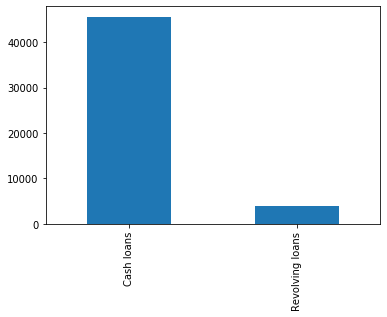

Columns: CODE_GENDER
Unique values: 3


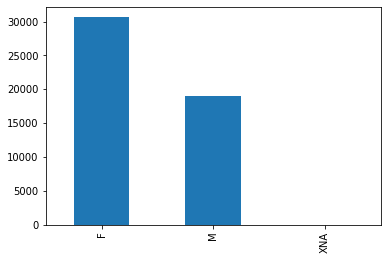

Columns: FLAG_OWN_CAR
Unique values: 2


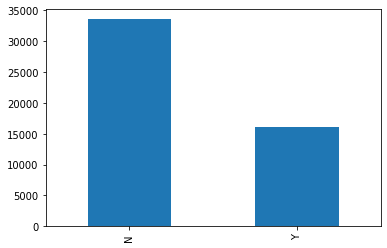

Columns: FLAG_OWN_REALTY
Unique values: 2


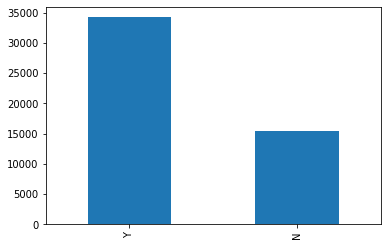

Columns: NAME_TYPE_SUITE
Unique values: 8


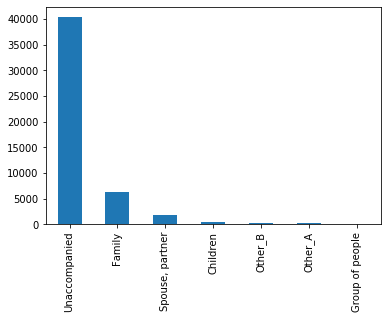

Columns: NAME_INCOME_TYPE
Unique values: 6


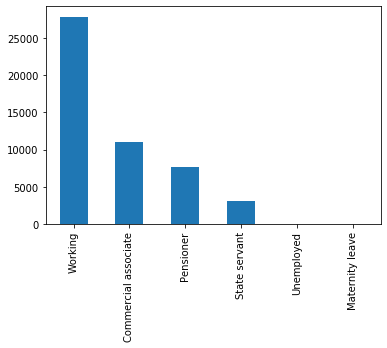

Columns: NAME_EDUCATION_TYPE
Unique values: 5


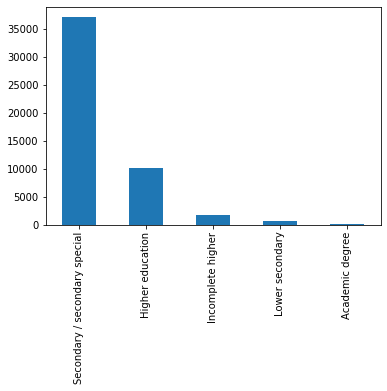

Columns: NAME_FAMILY_STATUS
Unique values: 5


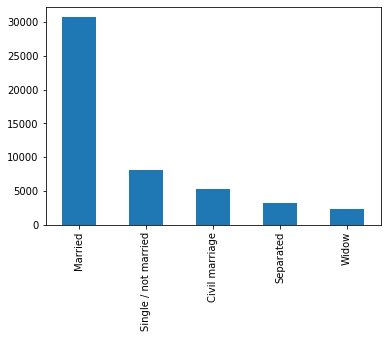

Columns: NAME_HOUSING_TYPE
Unique values: 6


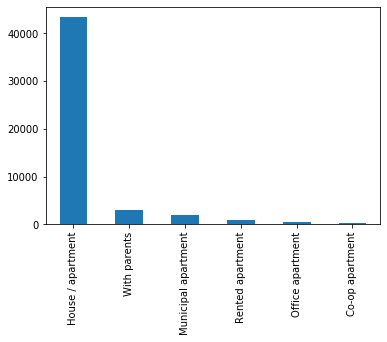

Columns: OCCUPATION_TYPE
Unique values: 19


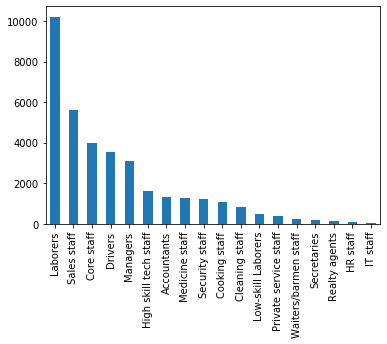

Columns: WEEKDAY_APPR_PROCESS_START
Unique values: 7


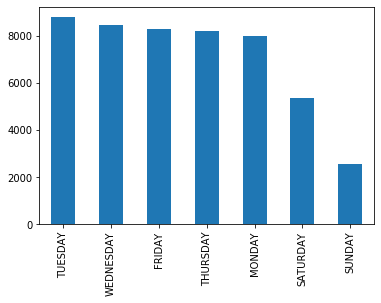

In [45]:
for column in categoric_columns:
    if len(data_under[column].unique()) < 21:
        print(f'Columns: {column}')
        print(f'Unique values: {len(data_under[column].unique())}')
        data_under[column].value_counts().plot.bar()
        plt.show()

Columns: CNT_CHILDREN
Unique values: 11


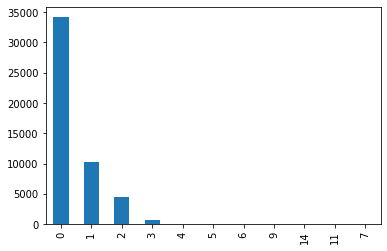

Columns: FLAG_MOBIL
Unique values: 1


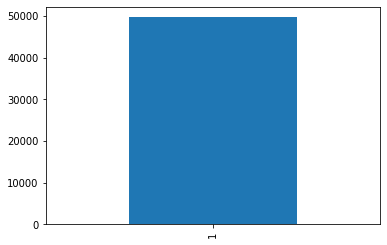

Columns: FLAG_EMP_PHONE
Unique values: 2


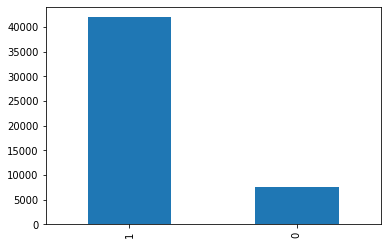

Columns: FLAG_WORK_PHONE
Unique values: 2


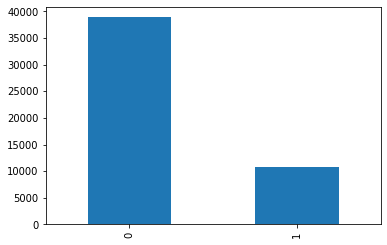

Columns: FLAG_CONT_MOBILE
Unique values: 2


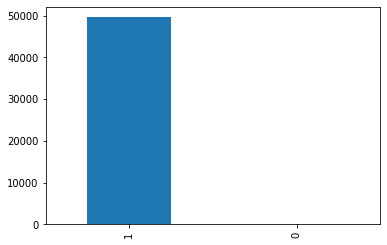

Columns: FLAG_PHONE
Unique values: 2


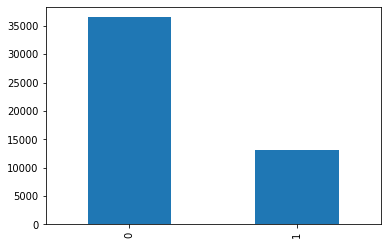

Columns: FLAG_EMAIL
Unique values: 2


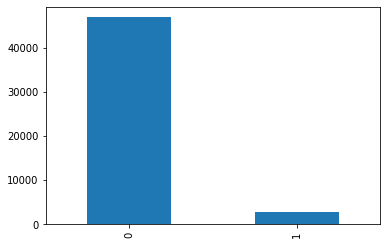

Columns: CNT_FAM_MEMBERS
Unique values: 13


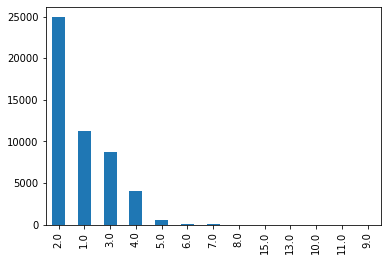

Columns: REGION_RATING_CLIENT
Unique values: 3


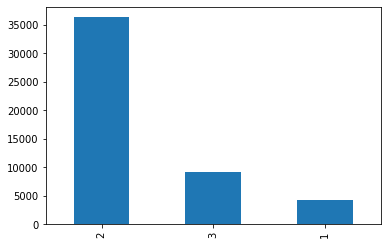

Columns: REGION_RATING_CLIENT_W_CITY
Unique values: 3


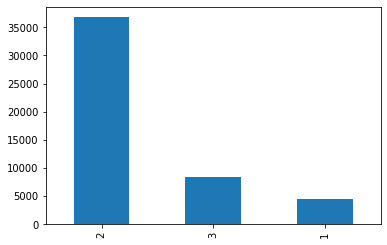

Columns: REG_REGION_NOT_LIVE_REGION
Unique values: 2


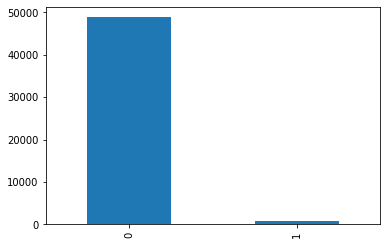

Columns: REG_REGION_NOT_WORK_REGION
Unique values: 2


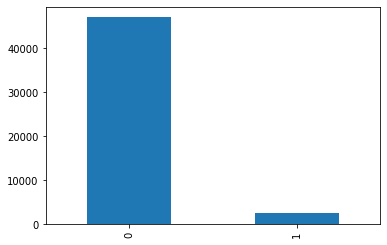

Columns: LIVE_REGION_NOT_WORK_REGION
Unique values: 2


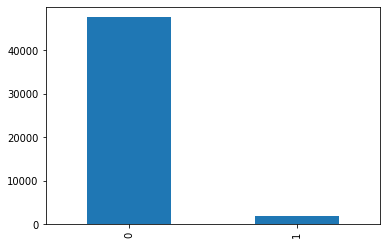

Columns: REG_CITY_NOT_LIVE_CITY
Unique values: 2


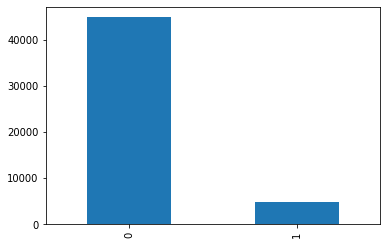

Columns: REG_CITY_NOT_WORK_CITY
Unique values: 2


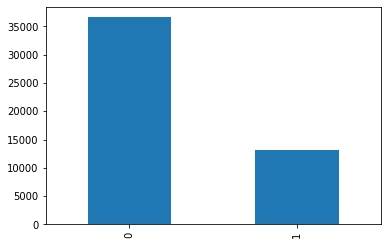

Columns: LIVE_CITY_NOT_WORK_CITY
Unique values: 2


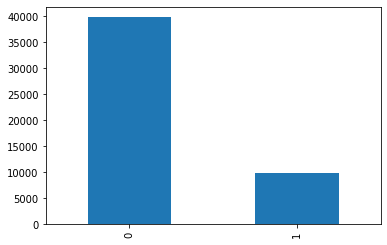

Columns: DEF_30_CNT_SOCIAL_CIRCLE
Unique values: 9


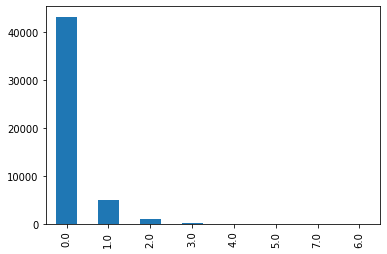

Columns: DEF_60_CNT_SOCIAL_CIRCLE
Unique values: 8


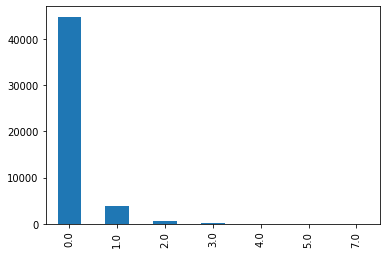

Columns: FLAG_DOCUMENT_2
Unique values: 2


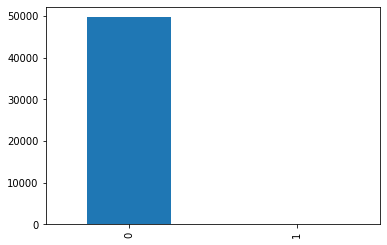

Columns: FLAG_DOCUMENT_3
Unique values: 2


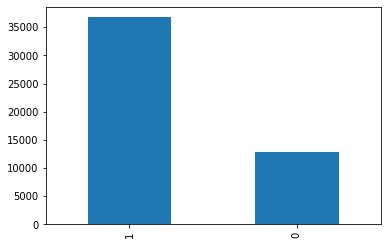

Columns: FLAG_DOCUMENT_4
Unique values: 2


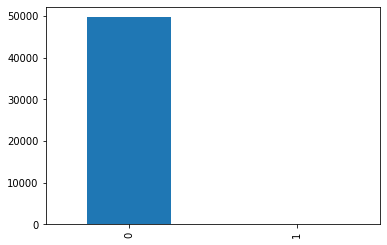

Columns: FLAG_DOCUMENT_5
Unique values: 2


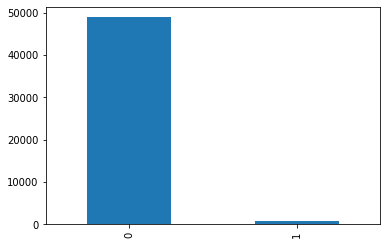

Columns: FLAG_DOCUMENT_6
Unique values: 2


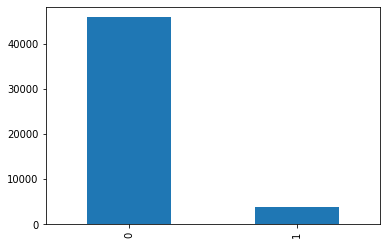

Columns: FLAG_DOCUMENT_7
Unique values: 2


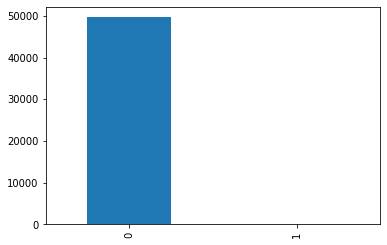

Columns: FLAG_DOCUMENT_8
Unique values: 2


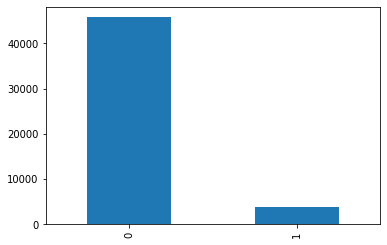

Columns: FLAG_DOCUMENT_9
Unique values: 2


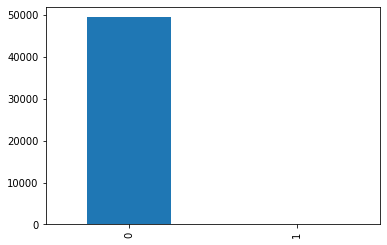

Columns: FLAG_DOCUMENT_10
Unique values: 1


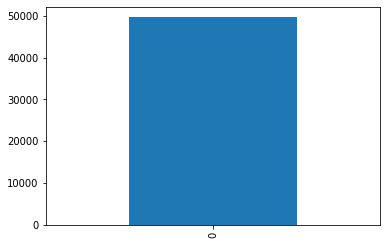

Columns: FLAG_DOCUMENT_11
Unique values: 2


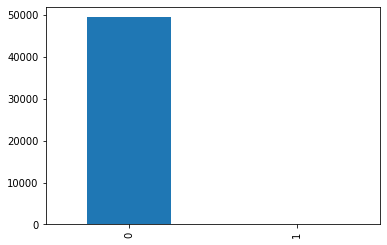

Columns: FLAG_DOCUMENT_12
Unique values: 1


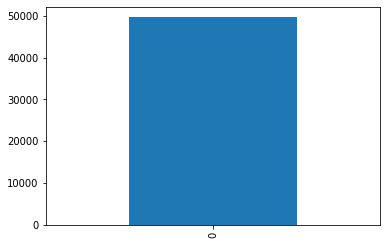

Columns: FLAG_DOCUMENT_13
Unique values: 2


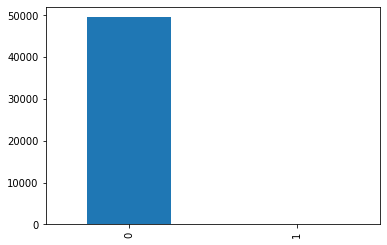

Columns: FLAG_DOCUMENT_14
Unique values: 2


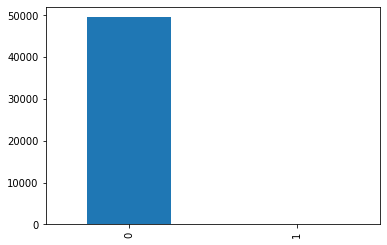

Columns: FLAG_DOCUMENT_15
Unique values: 2


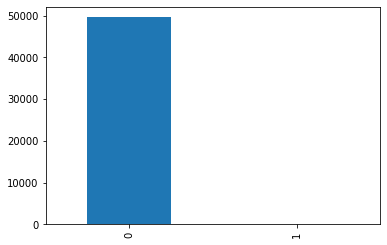

Columns: FLAG_DOCUMENT_16
Unique values: 2


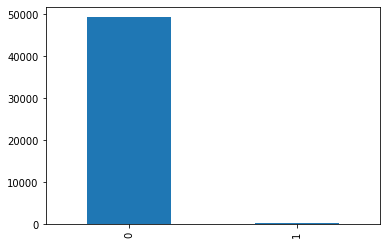

Columns: FLAG_DOCUMENT_17
Unique values: 2


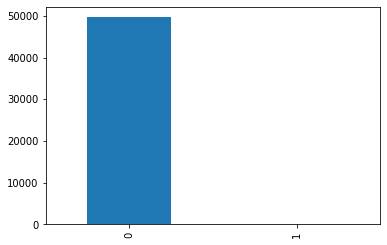

Columns: FLAG_DOCUMENT_18
Unique values: 2


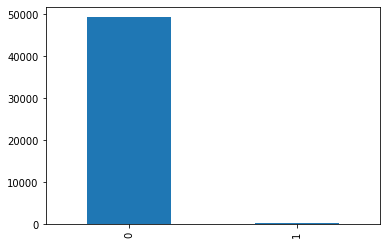

Columns: FLAG_DOCUMENT_19
Unique values: 2


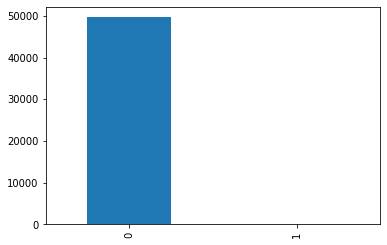

Columns: FLAG_DOCUMENT_20
Unique values: 2


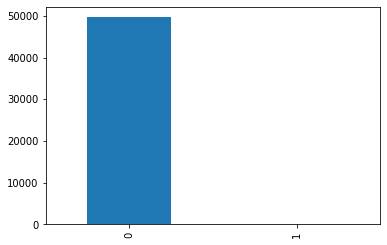

Columns: FLAG_DOCUMENT_21
Unique values: 2


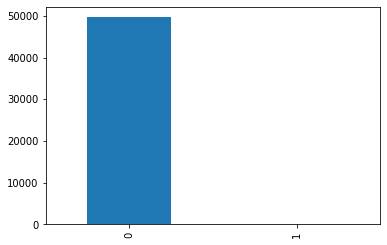

Columns: AMT_REQ_CREDIT_BUREAU_HOUR
Unique values: 4


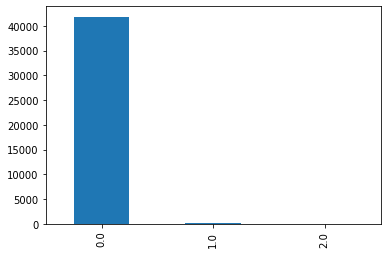

Columns: AMT_REQ_CREDIT_BUREAU_DAY
Unique values: 6


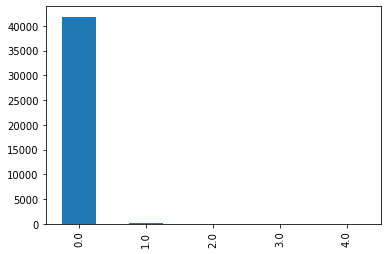

Columns: AMT_REQ_CREDIT_BUREAU_WEEK
Unique values: 9


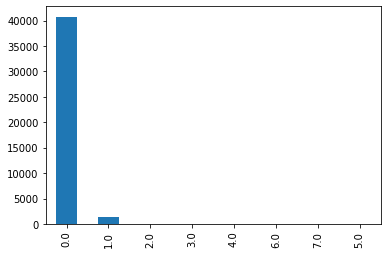

Columns: AMT_REQ_CREDIT_BUREAU_QRT
Unique values: 11


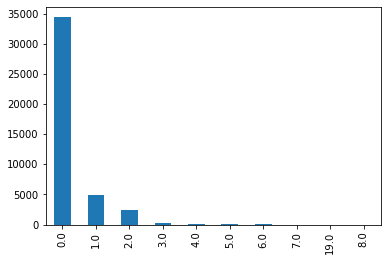

Columns: AMT_REQ_CREDIT_BUREAU_YEAR
Unique values: 18


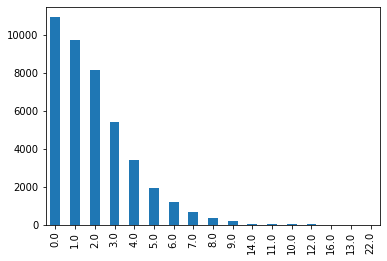

In [46]:
for column in numeric_columns:
    if len(data_under[column].unique()) < 21:
        print(f'Columns: {column}')
        print(f'Unique values: {len(data_under[column].unique())}')
        data_under[column].value_counts().plot.bar()
        plt.show()

## Transformery

teraz zdefiniuję transformery, z których będę korzystać do przetwarzania danych

In [47]:
class RemoveColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_remove: list):
        self.columns_to_remove = columns_to_remove
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X.drop(self.columns_to_remove, axis=1)

In [48]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, columns_to_select: list):
        self.columns_to_select = columns_to_select
    
    def fit( self, X, y = None ):
        return self 
    
    def transform( self, X, y = None ):
        return X[self.columns_to_select]

In [49]:
class ImputeNumColsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, method='mean'):
        self.method=method
        self.impute_values = {}
        
    def fit( self, X, y = None ):
        if self.method == 'mean':
            for col in X:
                mean = X[col].mean()
                self.impute_values[col] = mean
        # extra option is added here
        elif self.method == 'median':
            for col in X:
                median = X[col].median()
                self.impute_values[col] = median
            
        return self 
    
    def transform( self, X, y = None ):
        for col in X:
            value_to_impute = self.impute_values[col]
            X[col] = X[col].fillna(value_to_impute)
        return X

In [50]:
class ImputeCatColsTransformer(BaseEstimator, TransformerMixin):
    def __init__( self, method='mode'):
        self.method=method
        self.impute_values = {}
        
    def fit( self, X, y = None ):
        if self.method == 'mode':
            for col in X:
                mode = X[col].mode()[0]
                self.impute_values[col] = mode
        elif self.method == 'missing':
            for col in X:
                self.impute_values[col] = 'missing'
        return self 
    
    def transform( self, X, y = None ):
        for col in X:
            value_to_impute = self.impute_values[col]
            X[col] = X[col].astype('object')
            X[col] = X[col].fillna(value_to_impute)
        return X

## Pipeline

In [51]:
num_steps = [
            ('select_num_columns', SelectColumnsTransformer(numeric_columns)), 
            ('impute', ImputeNumColsTransformer(method='median')), 
            ('scaler', StandardScaler()), 
]

cat_steps = [
            ('select_cat_columns', SelectColumnsTransformer(categoric_columns)), 
            ('impute', ImputeCatColsTransformer(method='mode')), 
            ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
]

num_pipeline = Pipeline(num_steps)
cat_pipeline = Pipeline(cat_steps)

transformer_list = [ ('categorical_pipeline', cat_pipeline), 
                     ('numerical_pipeline', num_pipeline ) 
                   ]

combined_pipeline = FeatureUnion(transformer_list=transformer_list)

In [52]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed)

In [53]:
pipeline_1 = Pipeline(steps = [
                            ('combined_pipeline', combined_pipeline), 
                            ('classifier', LogisticRegression())
])

param_grid_1 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__penalty': ['l1', 'l2']
}

grid_1 = GridSearchCV(pipeline_1, param_grid_1, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 0.1, 'classifier__penalty': 'l1'}

In [54]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

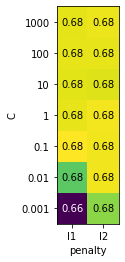

In [59]:
results = pd.DataFrame(grid_1.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 2)
heatmap(scores, xlabel='penalty', xticklabels=param_grid_1['classifier__penalty'], ylabel='C', yticklabels=param_grid_1['classifier__C'], cmap="viridis")
plt.show()

In [ ]:
#pipe_2 = Pipeline(steps = [
#                        ('combined_pipeline', combined_pipeline), 
#                        ('classifier', SVC(C=1, probability=True))
#])
#
#param_grid_2 = {
#            'classifier__C': [1],          
#            'classifier__gamma': [0.01]
#}
#
#grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)
#
#grid_2.fit(X_train, y_train)
#grid_2.best_params_

In [ ]:
#results = pd.DataFrame(grid_2.cv_results_)
#scores = np.array(results.mean_test_score).reshape(2, 1)
#heatmap(scores, xlabel='penalty', xticklabels=param_grid_1['log_reg__penalty'], ylabel='C', yticklabels=param_grid_1['log_reg__C'], cmap="viridis")
#plt.show()

In [74]:
pipe_3 = Pipeline(steps = [
                        ('combined_pipeline', combined_pipeline),  
                        ('classifier', DecisionTreeClassifier())
])

param_grid_3 = {
            'classifier__max_depth': [5,9,10,11,20,30],
            'classifier__min_samples_split': [2,3,5,10,20,30],
            'classifier__max_leaf_nodes': [10,14,15,16,20,30,40,50,70]
}


grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 40,
 'classifier__min_samples_split': 2}

In [75]:
pipe_4 = Pipeline(steps = [
                        ('combined_pipeline', combined_pipeline), 
                        ('classifier', ExtraTreesClassifier())
])

param_grid_4 = {
            'classifier__max_depth': [0.1, 1,5,10,20,30,40,100,200],
            'classifier__min_samples_split': [2,3,5,10,20,30,40],
            'classifier__max_leaf_nodes': [10,14,15,16,20,30,40,50,70]
}

grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__max_depth': 100,
 'classifier__max_leaf_nodes': 70,
 'classifier__min_samples_split': 5}

In [76]:
pipe_5 = Pipeline(steps = [
                        ('combined_pipeline', combined_pipeline), 
                        ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
])

param_grid_5 = {'classifier__n_estimators': [10, 50, 100, 150, 200, 300, 500],
              'classifier__max_leaf_nodes': [10, 20, 30, 50, 70, 100],
              'classifier__max_depth': [10, 20, 30, 50, 70, 100]
             }

grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 100,
 'classifier__n_estimators': 200}

In [63]:
pipe_6 = Pipeline(steps = [
                        ('combined_pipeline', combined_pipeline), 
                        ('classifier', KNeighborsClassifier(n_neighbors=3))
])

param_grid_6 = {
            'classifier__n_neighbors': [3, 5, 7, 10]
}

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__n_neighbors': 10}

In [77]:
pipe_7 = Pipeline(steps = [
                        ('combined_pipeline', combined_pipeline),
                        ('classifier', AdaBoostClassifier())
])

param_grid_7 = {'classifier__n_estimators': [2, 5, 10, 15, 20, 30, 50],
            'classifier__learning_rate': [0.1, 0.5, 1, 2, 3]}

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_

{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 50}

In [68]:
pipe_8 = Pipeline(steps = [
                        ('combined_pipeline', combined_pipeline),
                        ('classifier', GradientBoostingClassifier())
])

param_grid_8 = {'classifier__n_estimators': [2, 5, 10, 15, 20],
            'classifier__learning_rate': [0.1, 0.5, 1]}

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 15}

In [78]:
from sklearn import  metrics

models = []
models.append(('Logistic Regression', grid_1.best_estimator_))
#models.append(('SVM', grid_2.best_estimator_))
models.append(('Decission Tree', grid_3.best_estimator_))
models.append(('Extra Tree', grid_4.best_estimator_))
models.append(('Random Forest', grid_5.best_estimator_))
models.append(('KNeighbors', grid_6.best_estimator_))
models.append(('Ada Boost', grid_7.best_estimator_))
models.append(('Gradient Boost', grid_8.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test , model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))  
    roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

Logistic Regression
precision_score: 0.6795716639209226
recall_score: 0.6646525679758308
f1_score: 0.6720293249159963
accuracy_score: 0.6756294058408862
roc_auc_score: 0.7376570941200691
Decission Tree
precision_score: 0.665506742061766
recall_score: 0.6163141993957704
f1_score: 0.6399665376973753
accuracy_score: 0.6532729103726083
roc_auc_score: 0.7067922790855222
Extra Tree
precision_score: 0.645411812793787
recall_score: 0.6360523665659618
f1_score: 0.6406979103266383
accuracy_score: 0.6433031218529708
roc_auc_score: 0.6961485686816781
Random Forest
precision_score: 0.6724989707698641
recall_score: 0.6580060422960725
f1_score: 0.6651735722284434
accuracy_score: 0.6687814702920443
roc_auc_score: 0.730052766140425
KNeighbors
precision_score: 0.6381359961959105
recall_score: 0.5405840886203424
f1_score: 0.5853233017119179
accuracy_score: 0.6170191339375629
roc_auc_score: 0.6574711195893916
Ada Boost
precision_score: 0.6782077393075356
recall_score: 0.6706948640483383
f1_score: 0.674430

In [79]:
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=['Logistic Regression','Decission Tree','Extra Tree','Random Forest','KNeighbors', 'Ada Boost', 'Gradient Boost'])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,Logistic Regression,0.679572,0.664653,0.672029,0.675629,0.737657
1,Decission Tree,0.665507,0.616314,0.639967,0.653273,0.706792
2,Extra Tree,0.645412,0.636052,0.640698,0.643303,0.696149
3,Random Forest,0.672499,0.658006,0.665174,0.668781,0.730053
4,KNeighbors,0.638136,0.540584,0.585323,0.617019,0.657471
5,Ada Boost,0.678208,0.670695,0.674430,0.676234,0.738472
6,Gradient Boost,0.680816,0.665458,0.673050,0.676737,0.739137
